In [126]:
### Run this cell to import the packages you will need to unpack the dataset
# File manipulation and IO (input/output)
import os

# Import numerical and dataframe handling
import numpy as np

# Data preprocessing
from PIL import Image
from skimage.color import rgb2lab
from sklearn.model_selection import train_test_split

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import completeness_score
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf


# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib

!pip install innvestigate
import innvestigate
import innvestigate.utils as iutils




In [127]:
# Load the images
# Path to the directory containing PNG images
subdirectories = []
for entry in os.listdir('/kaggle/input/multiple-sclerosis/Multiple Sclerosis'):
    full_path = os.path.join('/kaggle/input/multiple-sclerosis/Multiple Sclerosis', entry)
    if os.path.isdir(full_path):
          subdirectories.append(full_path)

# Initialize lists to store images and corresponding labels
images = []
labels = []

# Load images and labels
for dataset_dir in subdirectories:
  for image_name in os.listdir(dataset_dir):
    if image_name.lower().endswith('.png'):
        image_path = os.path.join(dataset_dir, image_name)
        # Open the image using Pillow
        image = Image.open(image_path)
        # Optional: Resize the image to a consistent size (e.g., 128x128)
        image = image.resize((128, 128))
        # Convert the image to grayscale (L mode)
        image = image.convert("L")
        # Convert the image to a numpy array
        image_array = np.array(image)
        # Normalize the pixel values (divide by 255)
        image_array = image_array / 255.0
        # Append the image and label to the lists
        images.append(image_array)
        # Add the class label based on your dataset's structure
        # For example, if 'MS-A' is a class, you can extract the label from the filename.
        label = image_name.split('-')[0]  # Extracts 'MS' from 'MS-A (218).png'
        labels.append(label)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
print(labels)

# Convert string labels to integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}

labels = np.array([label_mapping[label] for label in labels], dtype=np.int32)

# Print the shape of the data for verification
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

['MS' 'MS' 'MS' ... 'C' 'C' 'C']
Images shape: (3427, 128, 128)
Labels shape: (3427,)


In [128]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shape of the data for verification
print("Training Images shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)
print("Validation Images shape:", X_val.shape)
print("Validation Labels shape:", y_val.shape)
print("Test Images shape:", X_test.shape)
print("Test Labels shape:", y_test.shape)


Training Images shape: (2192, 128, 128)
Training Labels shape: (2192,)
Validation Images shape: (549, 128, 128)
Validation Labels shape: (549,)
Test Images shape: (686, 128, 128)
Test Labels shape: (686,)


In [129]:
# Add 3rd channel to convert to RGB
X_train = np.repeat(X_train[:, :, :, np.newaxis], 3, axis=3)
X_val = np.repeat(X_val[:, :, :, np.newaxis], 3, axis=3)
X_test = np.repeat(X_test[:, :, :, np.newaxis], 3, axis=3)
print(X_train.shape)


(2192, 128, 128, 3)


In [130]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(labels))).astype(np.float32)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(np.unique(labels))).astype(np.float32)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(labels))).astype(np.float32)

print(y_test.shape)

(686, 2)


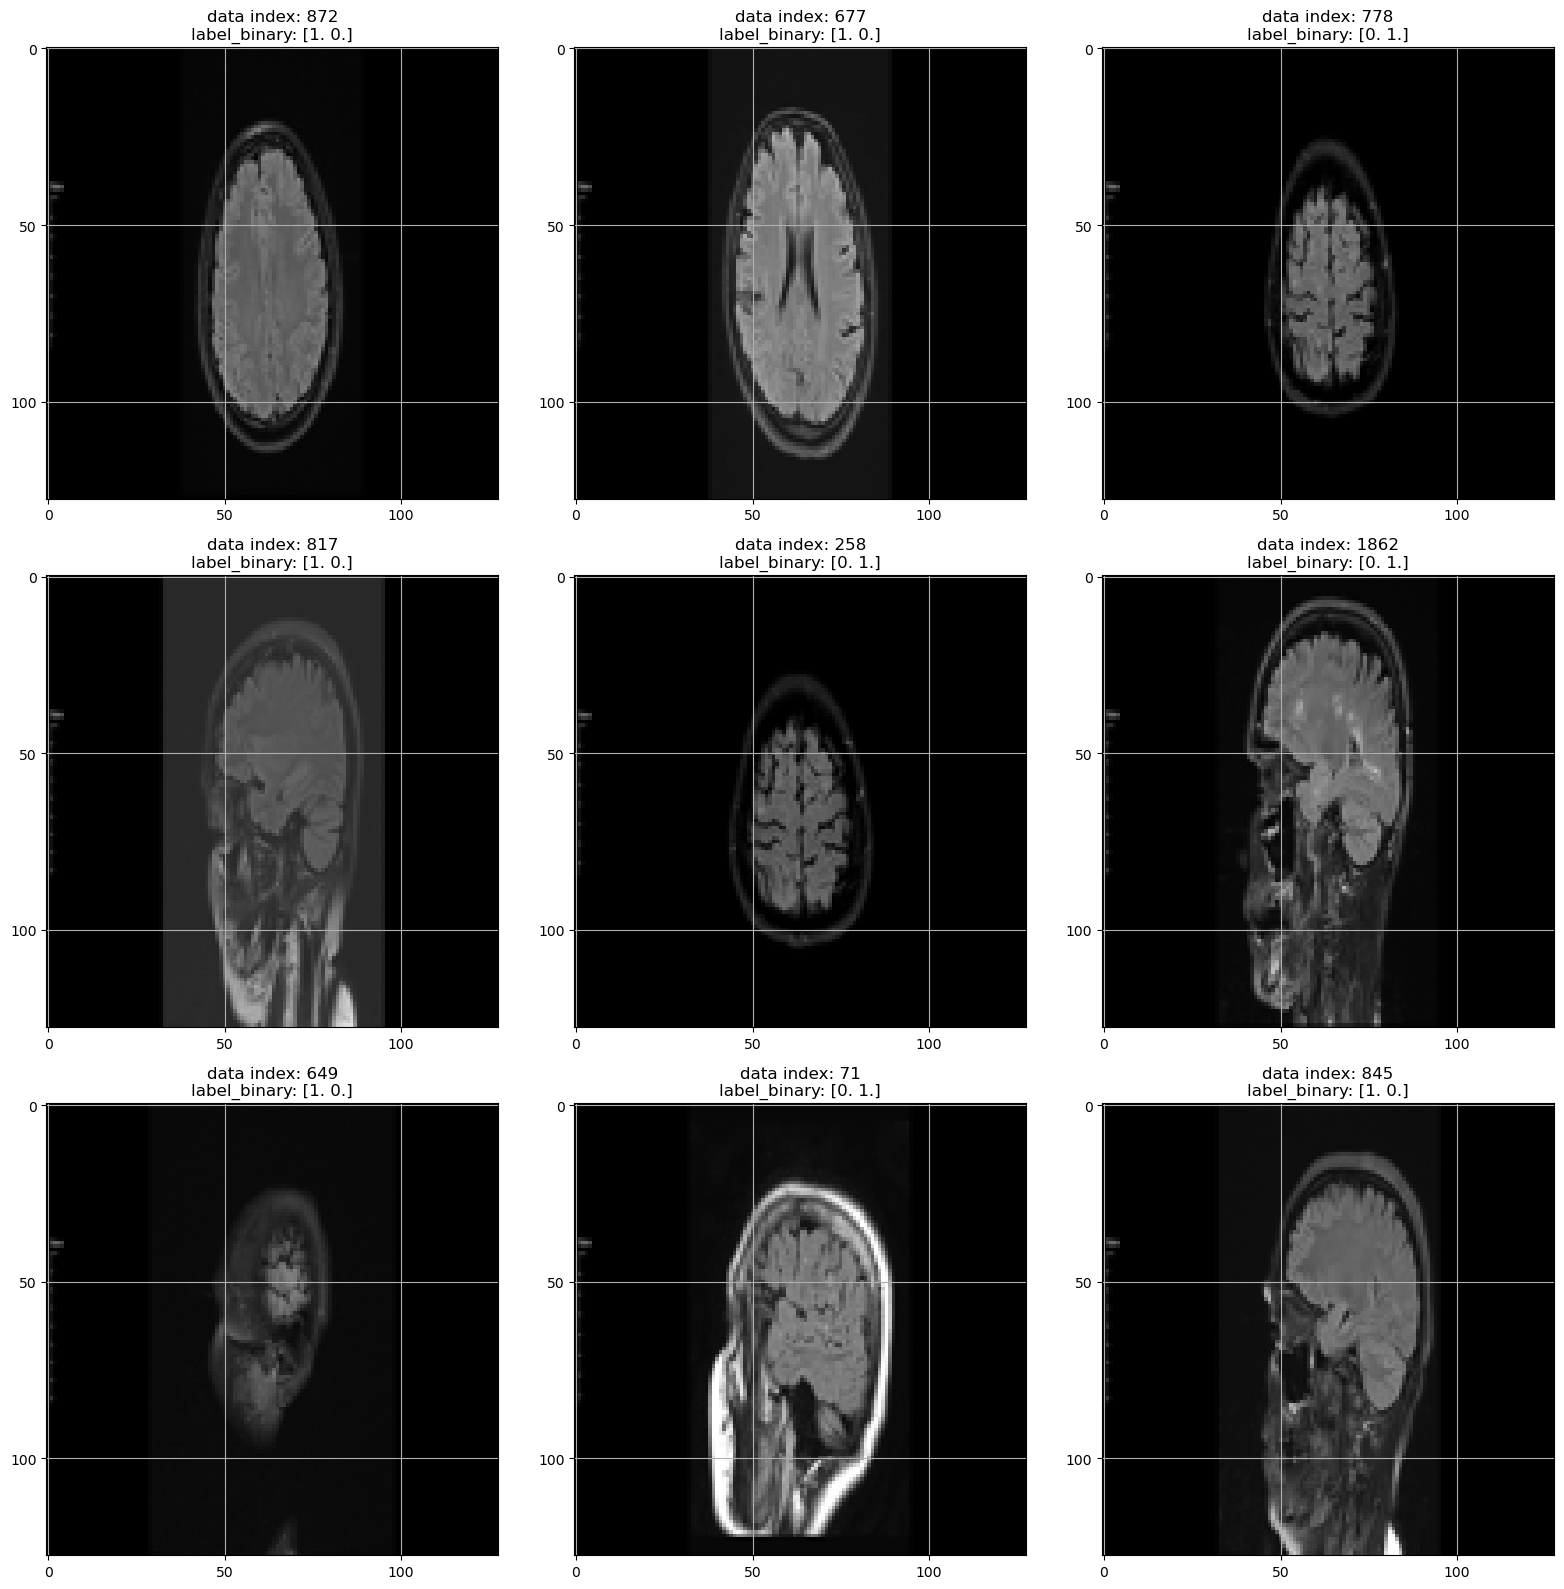

In [131]:
### Visualize Images in Training Set

fig = plt.figure(figsize = (16,16))

for i in range(9): # change these numbers to explore the training dataset further
  imgInd = np.random.randint(0, len(X_train))
  ax = plt.gcf().add_subplot(3, 3, i+1)
  ax.imshow(X_train[imgInd], cmap='gray', vmin=0, vmax=255)
  ax.set_title("data index: " + str(imgInd) + "\nlabel_binary: " +
            str(y_train[imgInd]))

  #set major tick marks every 50 pixels
  ax.xaxis.set_major_locator(MultipleLocator(50))
  ax.yaxis.set_major_locator(MultipleLocator(50))

  #turn on grid lines
  ax.grid(True)

fig.tight_layout()

In [132]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [133]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      4736      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 65536)            

In [134]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)
model.fit(X_train, y_train, epochs=30, batch_size=16, callbacks=[early_stopping,lr_scheduler], validation_data=(X_val, y_val))


Epoch 1/30


2024-02-18 21:11:59.722304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


137/137 [==============================] - 4s 16ms/step - loss: 0.5185 - accuracy: 0.7404 - val_loss: 0.5164 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - 2s 13ms/step - loss: 0.3770 - accuracy: 0.8234 - val_loss: 0.3687 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - 2s 13ms/step - loss: 0.2804 - accuracy: 0.8796 - val_loss: 0.2875 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/30
137/137 [==============================] - 2s 13ms/step - loss: 0.2250 - accuracy: 0.9078 - val_loss: 0.3128 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 5/30
137/137 [==============================] - 2s 13ms/step - loss: 0.2047 - accuracy: 0.9170 - val_loss: 0.2378 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 6/30
137/137 [==============================] - 2s 13ms/step - loss: 0.1575 - accuracy: 0.9329 - val_loss: 0.2198 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 7/30
137/137 [==============================] - 2s 13ms/step - loss: 

In [135]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_8 (7, 7, 3, 32)
conv2d_9 (3, 3, 32, 64)


In [136]:
filters , bias = model.layers[3].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


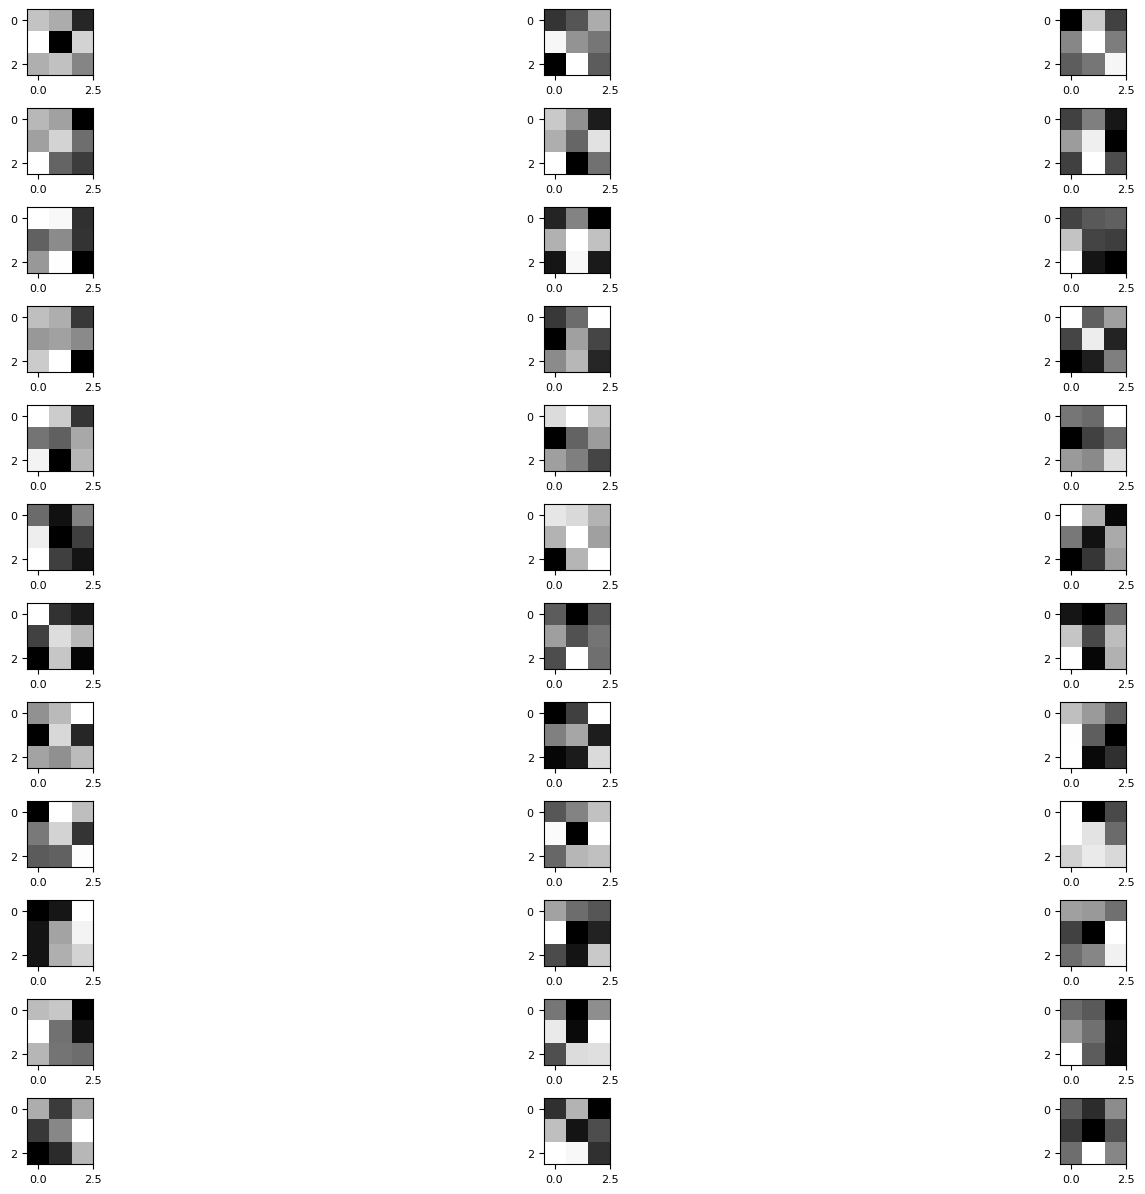

In [137]:
n_filters =12
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ix+=1
#plot the filters 
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0)
plt.show()

In [138]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_8 (None, 128, 128, 32)
3 conv2d_9 (None, 64, 64, 64)


In [139]:
model_layer = tf.keras.models.Model(inputs=model.inputs , outputs=model.layers[3].output)

In [140]:
# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input
image = load_img("/kaggle/input/multiple-sclerosis/Multiple Sclerosis/Control-Axial/C-A (10).png" , target_size=(128,128))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
print("done")

done


1/1 [==============================] - 0s 52ms/step


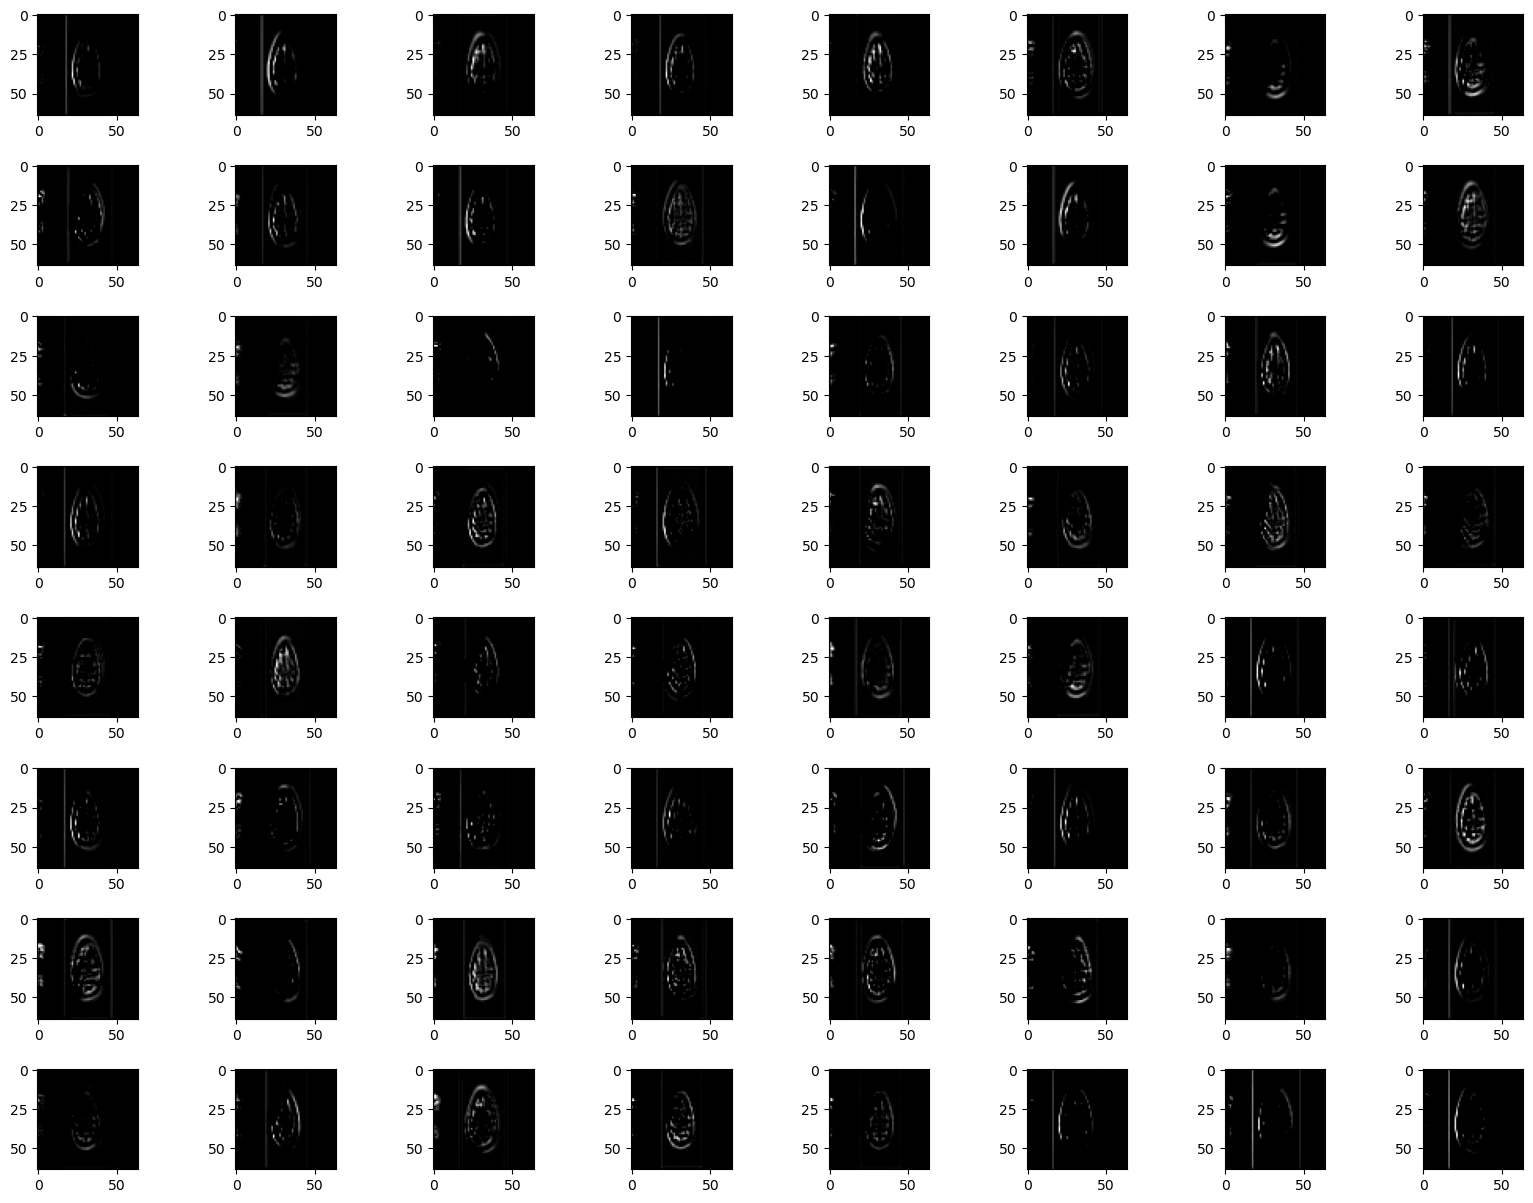

In [141]:
features = model_layer.predict(image)
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

In [142]:
print(image.shape)
preds=model.predict(image)
print(preds)
aggregated_pred = np.mean(preds)  # You can use np.max() or np.sum() as well

# Apply softmax
probs = 1 / (1 + np.exp(-aggregated_pred))  # Sigmoid activation for binary classification

print("Probability of class 1:", probs)
print("Probability of class 2:", 1 - probs)  # Assuming binary classification

(1, 128, 128, 3)
1/1 [==============================] - 0s 71ms/step
[[1. 0.]]
Probability of class 1: 0.6224593286296588
Probability of class 2: 0.3775406713703412
